# Programming Project 1

## Naive Bayes Classifier for Sentiment Analysis

John Koo

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from pp1_functions import open_reviews, learning_curve, kfold_cv
import warnings

warnings.filterwarnings('ignore')

In [2]:
# --- constants and globals --- #

# number of folds
K = 10 

# increment the subsampling by this much
# i.e., subsampling proportions are [.1, .2, .3, ..., .9, 1.]
LEARNING_CURVE_STEP = .1

# subdirectory where the data live
DATA_SUBDIR = 'sentiment labelled sentences'

# the file names of the data
DATA_FILES = ['amazon_cells_labelled.txt',
              'imdb_labelled.txt',
              'yelp_labelled.txt']

#### Some notes on implementation

The basic classification algorithm is this: 

Given a sentence of length $k$ (which we think of as a set):

$\{w_1, w_2, ..., w_k\}$

compute the log likelihood based on a training set:

$\ell = \log p_{w_1} + \cdots + \log p_{w_k}$

Where $p_{w_i}$ is the number of times word $w_i$ appears in the training set divided by the total number of words in the training set (in the maximum likelihood case).

We divide the training set into labeled classes (in our case, 0 and 1, signifying negative and positive sentiment respectively), and compare the log likelihoods for each training subset. We also must add in information about the proportion of each class, so the log likelihood becomes:

$\ell = (\log q_{c_j}) + (\log p_{w_1 | c_j} + \cdots + \log p_{w_k | c_j})$

Where $q_{c_j}$ is the proportion of times class $c_j$ appears in the training set, and this time, $p_{w_i | c_j}$ is the proportion of words that are $w_i$ in class $c_j$. Whichever results in the highest log likelihood is what the sentence is predicted to be classified as. 

The problem with this classifier is that the number of words in the English language (+ possible typos and nonsense inputs) is several orders of mangitude greater than the number of sentences in the training set. It's very likely that the sentence we want to classify has words that do not appear in the training set. This results in $\ell = -\infty$. If we get $-\infty$ for only some of the classes and not all, then it's simple enough to just look at the classes where $\ell \neq -\infty$ (i.e., if $\ell = -\infty$ for sentiment = 0 and $\ell = -20$ for sentiment = 1, then we would predict that the sentence is of sentiment = 1). If, however, we get $\ell = -\infty$ for all classes (i.e., the sentence contains a word that doesn't appear in any of the classes in the training set), then it's not clear how to proceed. For the sake of coming up with a valid prediction, if this happens, we will randomly choose a class, weighted by how frequently each class appears in the training set. Note that this is not a problem with MAP prediction.

### Experiment 1

For this experiment, we want to compare the learning curves for $m=0$ (maximum likelihood) vs. $m=1$ (Dirichlet prior with $\alpha_i = 1$)

In [3]:
# go to subdirectory with data
os.chdir(DATA_SUBDIR)

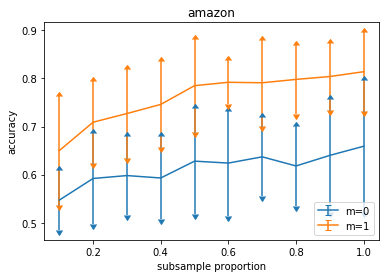

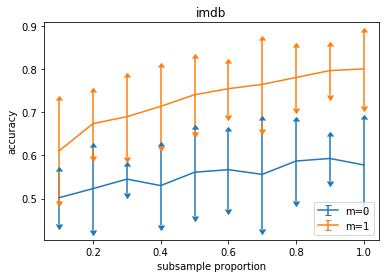

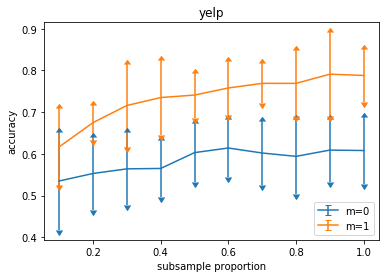

In [4]:
# for each dataset
for data_file in DATA_FILES:
    dataset_name = data_file.split('_')[0]

    # read the data
    reviews, ratings = open_reviews(data_file)

    # for each value of m specified by the assignment
    # compute the accuracy curves
    fig = plt.figure()
    for m in [0, 1]:
        # compute accuracies for each subsample proportion and fold
        accuracies = learning_curve(reviews, ratings,
                                    m,
                                    K, LEARNING_CURVE_STEP)

        # compute the mean and std accuracy for each subsample proportion
        mean_accs = [np.mean(accuracy) for accuracy in accuracies]
        std_accs = [np.std(accuracy) for accuracy in accuracies]

        # plot
        proportions = np.arange(LEARNING_CURVE_STEP, 1 + LEARNING_CURVE_STEP,
                                LEARNING_CURVE_STEP)
        plt.errorbar(proportions, mean_accs,
                     yerr=[2 * s for s in std_accs],
                     uplims=True, lolims=True,
                     label=f'm={m}')
    plt.legend(loc='lower right')
    plt.xlabel('subsample proportion')
    plt.ylabel('accuracy')
    plt.title(dataset_name)
    plt.show()

The above plots track the mean accuracy across the 10 folds at each subsample proportion. 

As expected, we get better performance as we increase the subsample proportion. We can also see that $m=1$ performs better than $m=0$ across the board, which is also somewhat expected--in most cases, a validation sentence would have a word that did not appear in either class of the training set, and setting $m > 0$ mitigated these cases.

### Experiment 2

This time we try $m = 0, .1, .2, ..., .9, 1, 2, ..., 9, 10$.

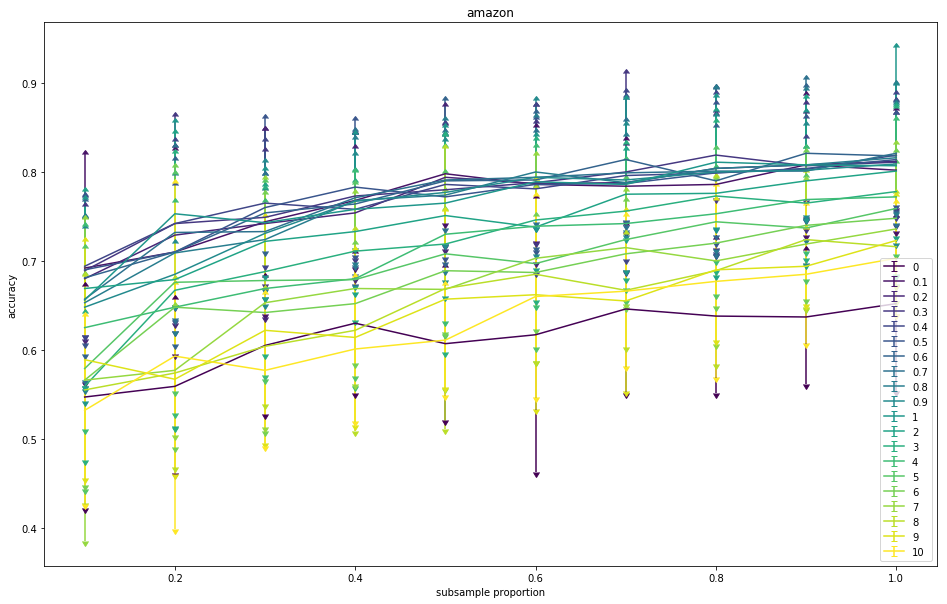

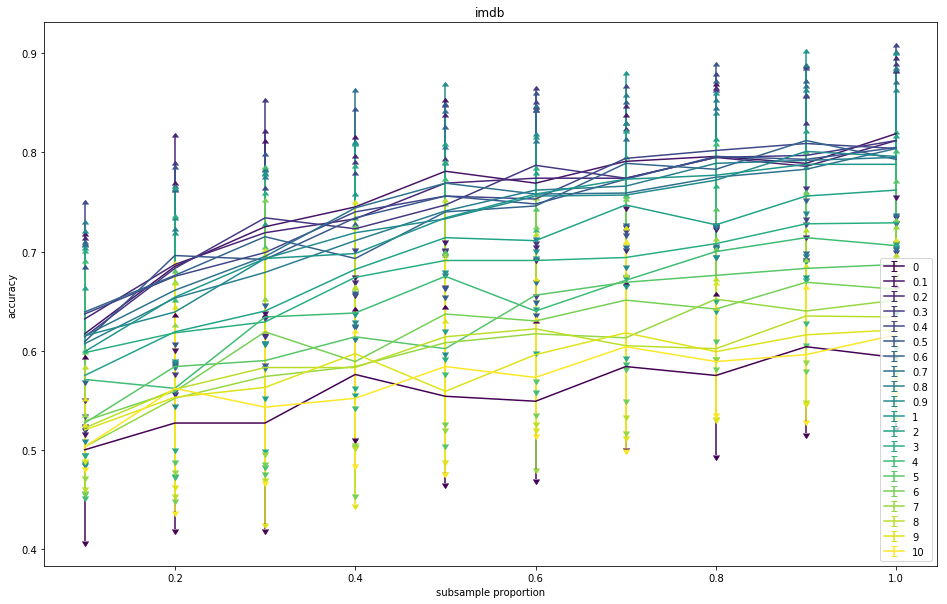

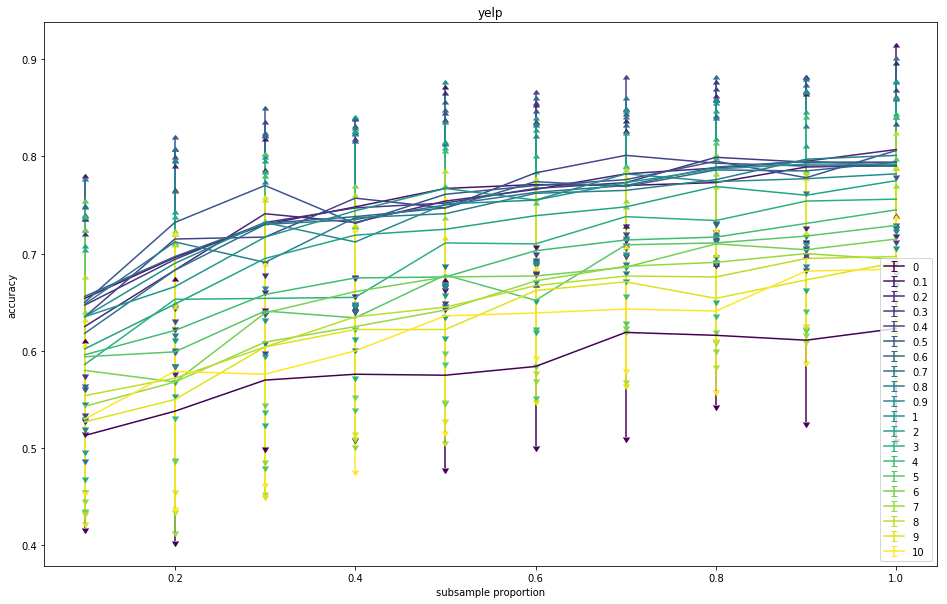

In [5]:
# values of m specified by the assignment
m_values = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# colors for plotting
colormap = plt.cm.viridis(np.linspace(0, 1, len(m_values)))

# for each dataset
for data_file in DATA_FILES:
    dataset_name = data_file.split('_')[0]

    # read the data
    reviews, ratings = open_reviews(data_file)

    # for each value of m specified by the assignment
    # compute the accuracy curves
    fig = plt.figure(figsize=(16, 10))
    for i, m in enumerate(m_values):
        # compute accuracies for each subsample proportion and fold
        accuracies = learning_curve(reviews, ratings,
                                    m,
                                    K, LEARNING_CURVE_STEP)

        # compute the mean and std accuracy for each subsample proportion
        mean_accs = [np.mean(accuracy) for accuracy in accuracies]
        std_accs = [np.std(accuracy) for accuracy in accuracies]

        # plot
        proportions = np.arange(LEARNING_CURVE_STEP, 1 + LEARNING_CURVE_STEP,
                                LEARNING_CURVE_STEP)
        plt.errorbar(proportions, mean_accs,
                     yerr=[2 * s for s in std_accs],
                     uplims=True, lolims=True,
                     label=m,
                     c=colormap[i])
    plt.legend(loc='lower right')
    plt.xlabel('subsample proportion')
    plt.ylabel('accuracy')
    plt.title(dataset_name)
    plt.show()

First, we can see that $m=0$ is the worst performer across the board.

The plots suggest that lower values of $m$ ($m \in (0, 1)$), and once we go past $m=1$, we start seeing a drop in performance. Perhaps a better way to illustrate this is by setting subsample proportion = 1 and then plotting accuracy vs. m:

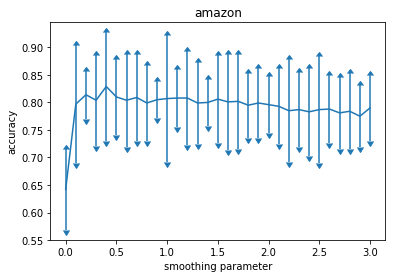

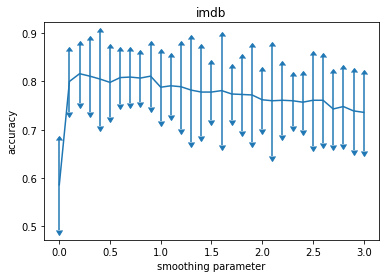

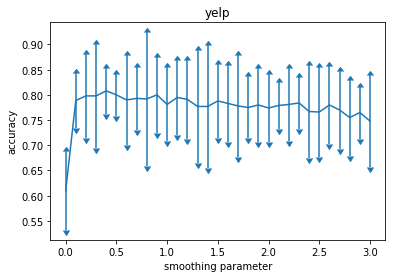

In [6]:
# use a different set of smoothing parameter values this time
m_values = np.linspace(0, 3, 31)

# colors for plotting
colormap = plt.cm.viridis(np.linspace(0, 1, len(m_values)))

# for each dataset
for data_file in DATA_FILES:
    dataset_name = data_file.split('_')[0]

    # read the data
    reviews, ratings = open_reviews(data_file)

    # for each value of m
    fig = plt.figure()
    all_accuracies = []
    for i, m in enumerate(m_values):
        # compute accuracies for each fold
        accuracies = kfold_cv(reviews, ratings, 
                              method='map', alpha=m)
        all_accuracies.append(accuracies)

    # compute the mean and std accuracy for each m
    mean_accs = [np.mean(accuracy) for accuracy in all_accuracies]
    std_accs = [np.std(accuracy) for accuracy in all_accuracies]

    # plot
    plt.errorbar(m_values, mean_accs,
                 yerr=[2 * s for s in std_accs],
                 uplims=True, lolims=True)
    plt.xlabel('smoothing parameter')
    plt.ylabel('accuracy')
    plt.title(dataset_name)
    plt.show()

The plots suggest that accuracy starts to steadily decrease as $m$ increases past around $0.5$.